# Perfect-Model Predictability Demo

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

**What's a perfect-model framework simulation?**

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

**Some papers including perfect-model simulations:**

- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Li, Hongmei, Tatiana Ilyina, Wolfgang A. Müller, and Frank Sienz. “Decadal Predictions of the North Atlantic CO2 Uptake.” Nature Communications 7 (March 30, 2016): 11076. https://doi.org/10/f8wkrs. (Reference for visualization)
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

In [1]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model,  
                                 compute_persistence)
from climpred.bootstrap import bootstrap_perfect_model, varweighted_mean_period_threshold, DPP_threshold
from climpred.tutorial import load_dataset
from climpred.graphics import plot_bootstrapped_skill_over_leadyear
from climpred.stats import (decorrelation_time, varweighted_mean_period, 
                            autocorr, DPP)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Load sample data

Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

### 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **init**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [2]:
ds = load_dataset('MPI-PM-DP-1D')
control = load_dataset('MPI-control-1D')

choose varname, area, period

In [3]:
varname='tos'
area='North_Atlantic'
period='ym'

In [4]:
ds = ds.sel(area=area,period=period)[varname]
control = control.sel(area=area,period=period)[varname]
del ds['period']
del ds['area']
del control['period']
del control['area']

## Results
- Bootstrap with replacement: Goddard et al. 2013
- Visualization: Li et al. 2016
    - Bootstrap with replacement
    - p_value: probability that uninitialized or persistence forecast beats initialized forecast based on N=1000 bootstrapping with replacement

In [5]:
sig = 95
bootstrap = 20
comparison='m2e'

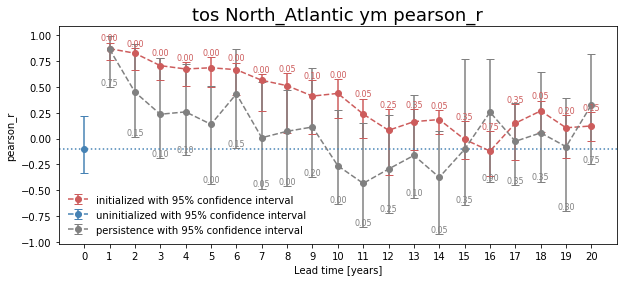

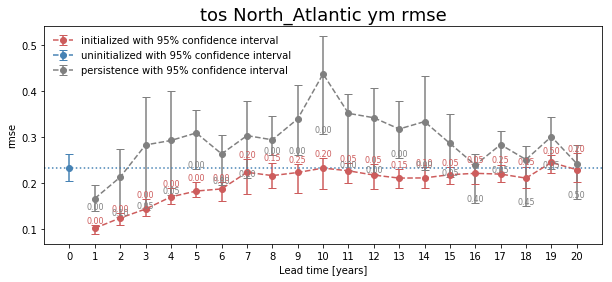

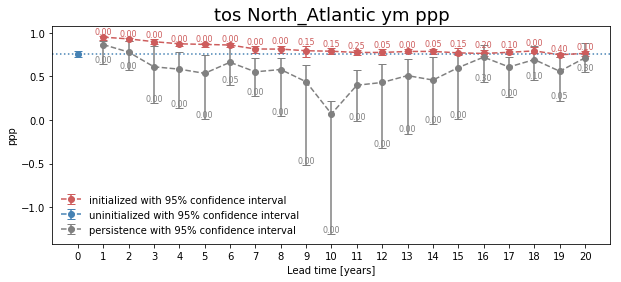

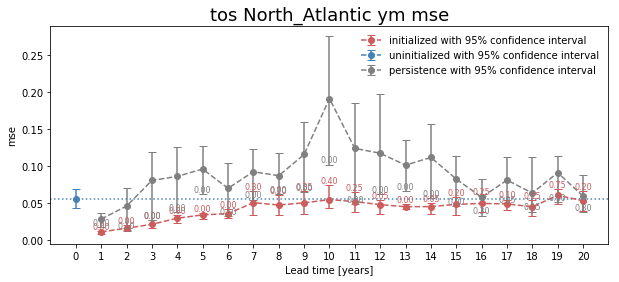

In [6]:
for metric in ['pearson_r', 'rmse', 'ppp', 'mse']:
    bootstrapped = bootstrap_perfect_model(ds, control, metric=metric, 
                                           comparison=comparison, bootstrap=bootstrap, 
                                           sig=sig)

    plot_bootstrapped_skill_over_leadyear(bootstrapped, sig)
    plt.title(' '.join([varname, area, period, metric]),fontsize=18)
    plt.ylabel(metric)
    plt.show()

### Different comparisons lead to different skill score magnitude by design

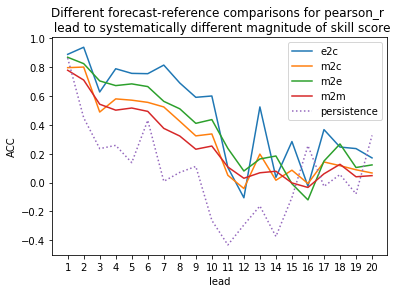

In [7]:
for c in ['e2c','m2c','m2e','m2m']:
    compute_perfect_model(ds, control, metric='pearson_r', comparison=c).plot(label=c)
compute_persistence(ds, control).plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

### 3-dimensional

Data is stored on curvilinear grid: lon(y, x), lat(y, x). The computation of skill is independent of any extra dimensions to `init`, `member`, `lead`.

In [8]:
ds3d = load_dataset('MPI-PM-DP-3D').sel(init=3014).expand_dims('init')[varname]
control3d = load_dataset('MPI-control-3D')[varname]

choose predictability metric and comparison

In [9]:
metric='rmse'
comparison='m2e'

### Skill over lead year

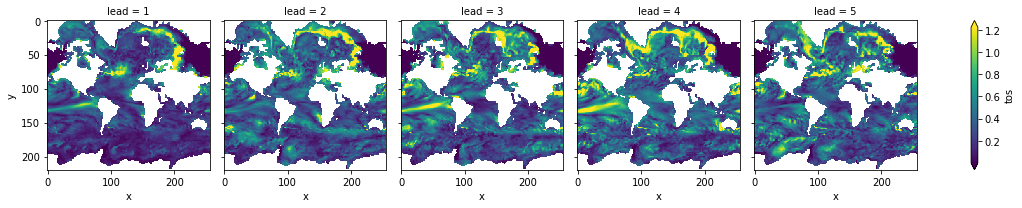

In [11]:
compute_perfect_model(ds3d, control3d, metric=metric, comparison=comparison).plot(col='lead', robust=True, yincrease=False)

### Significant skill based on bootstrapping
grid cells with larger than 5% probability (that persistence/uninitialized ensembles perform better than initialized ensembles) are masked.

In [12]:
bootstrapped3d = bootstrap_perfect_model(ds3d, control3d, metric=metric, comparison=comparison, 
                     sig=sig, bootstrap=bootstrap)

In [13]:
init_skill_better_than_pers = bootstrapped3d.sel(results='skill',kind='init').where(bootstrapped3d.sel(results='p',kind='pers')>0.05)
init_skill_better_than_uninit = bootstrapped3d.sel(results='skill',kind='init').where(bootstrapped3d.sel(results='p',kind='uninit')>0.05)

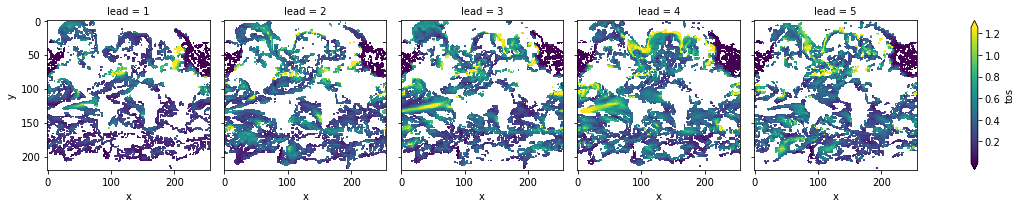

In [14]:
init_skill_better_than_pers.plot(col='lead', robust=True, yincrease=False)

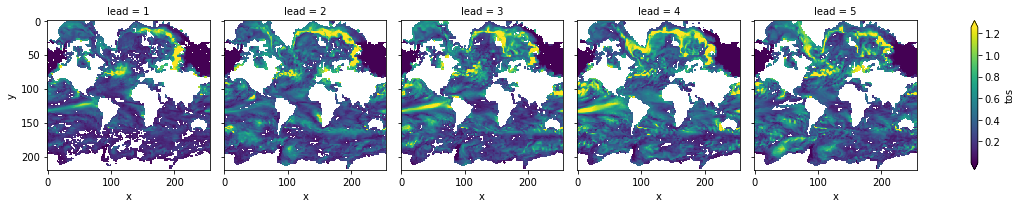

In [15]:
init_skill_better_than_uninit.plot(col='lead', robust=True, yincrease=False)

### Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances for decadal predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

### DPP

### Resplandy 2015, Seferian 2018 method

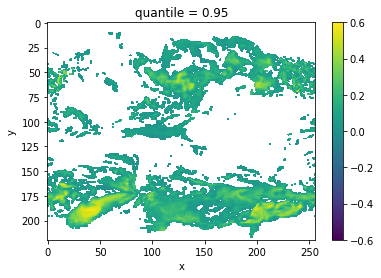

In [16]:
threshold = DPP_threshold(control3d, m=10, chunk=False, bootstrap=bootstrap)
DPP10 = DPP(control3d, m=10, chunk=False)
DPP10.where(DPP10>threshold).plot(yincrease=False,vmax=.6, cmap='viridis')

### Original Boer 2004 implementation

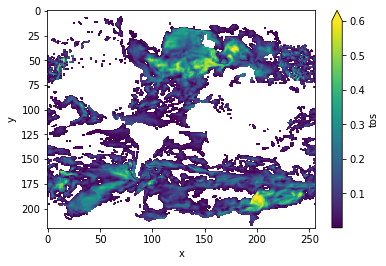

In [17]:
threshold = DPP_threshold(control3d, m=10, chunk=True, bootstrap=bootstrap)
DPP10 = DPP(control3d, m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6, cmap='viridis')

yields similar results

### varweigthed mean period

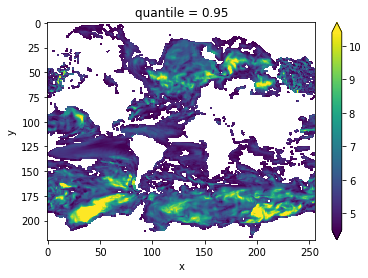

In [18]:
threshold = varweighted_mean_period_threshold(control3d, bootstrap=bootstrap)
vwmp = varweighted_mean_period(control3d,time_dim='time')
vwmp.where(vwmp > threshold).plot(yincrease=False, robust=True)

### Lag1 autocorrelation

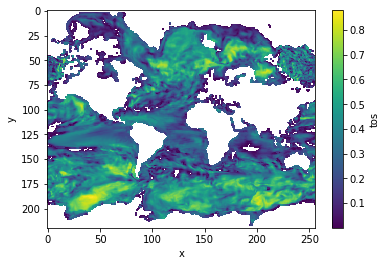

In [19]:
corr_ef = autocorr(control3d,dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

### Decorrelation time

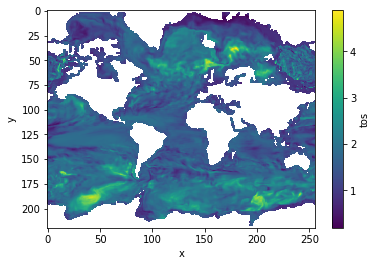

In [20]:
decorr_time = decorrelation_time(control3d)
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)